-----------
### CNN for pretraining weight classification like last week

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

# PyTorch TensorBoard support
# from torch.utils.tensorboard import SummaryWriter
# !pip install tensorboardX
# from tensorboardX import SummaryWriter
from datetime import datetime


transform = transforms.Compose(
        [transforms.Resize((32, 32)),
         transforms.Grayscale(num_output_channels=3),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Create datasets for training & validation, download if necessary
# handwritten
# training_set = torchvision.datasets.USPS('./data', train=True, transform=transform, download=True)
# validation_set = torchvision.datasets.USPS('./data', train=False, transform=transform, download=True)
training_set = torchvision.datasets.MNIST('/home/crueang/Chaks/AIOT/5_1_inclass/data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.MNIST('/home/crueang/Chaks/AIOT/5_1_inclass/data', train=False, transform=transform, download=True)
# object recognition
# training_set = torchvision.datasets.Caltech101('./data', transform=transform, download=True)
# train_size = int(0.8 * len(training_set))
# test_size = len(training_set) - train_size
# training_set, validation_set = torch.utils.data.random_split(training_set, [train_size, test_size])


# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=16, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=16, shuffle=False)

# Class labels
# classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:11<00:00, 873575.17it/s] 


Extracting /home/crueang/Chaks/AIOT/5_1_inclass/data/MNIST/raw/train-images-idx3-ubyte.gz to /home/crueang/Chaks/AIOT/5_1_inclass/data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 106352.86it/s]


Extracting /home/crueang/Chaks/AIOT/5_1_inclass/data/MNIST/raw/train-labels-idx1-ubyte.gz to /home/crueang/Chaks/AIOT/5_1_inclass/data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:02<00:00, 778620.54it/s] 


Extracting /home/crueang/Chaks/AIOT/5_1_inclass/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /home/crueang/Chaks/AIOT/5_1_inclass/data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2758148.08it/s]


Extracting /home/crueang/Chaks/AIOT/5_1_inclass/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /home/crueang/Chaks/AIOT/5_1_inclass/data/MNIST/raw

Training set has 60000 instances
Validation set has 10000 instances


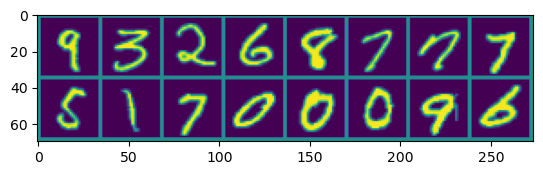

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg)
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
# print('  '.join(classes[labels[j]] for j in range(16)))

In [3]:
def plot_graph(history):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(10)
    fig.suptitle("Train vs Validation")
    ax1.plot(history["train_acc"], label="Train")
    ax1.plot(history["validate_acc"], label="Validation")
    ax1.legend()
    ax1.set_title("Accuracy")

    ax2.plot(history["train_loss"], label="Train")
    ax2.plot(history["validate_loss"], label="Validation")
    ax2.legend()
    ax2.set_title("Loss")
    fig.show()

In [4]:
import os
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import time

#---Variable initialization---
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#-----------------------------

# PyTorch models inherit from torch.nn.Module
#---CNN---
class handwrittenmodel(nn.Module):
    def __init__(self):
        super(handwrittenmodel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=4, stride=2, padding=1)  # 1x32x32 ---> 10x16x16
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # 10x16x16 ---> 10x8x8
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, stride=1, padding=0) # 10x8x8 ---> 20x6x6
        self.fc1 = nn.Linear(20 * 3 * 3, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 20 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Model init
model = handwrittenmodel().to(device)
summary(model, (3, 32, 32))

# Loss function
loss_fn = torch.nn.CrossEntropyLoss()
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Initializing in a separate cell so we can easily add more epochs to the same run
# timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS_pretrained = 10
path_save_cp = '/home/crueang/Chaks/AIOT/5_1_inclass/cp/'
best_vloss = 1_000_000.
training_logs = {"train_loss": [],  "train_acc": [], "validate_loss": [], "validate_acc": []}

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 16, 16]             490
         MaxPool2d-2             [-1, 10, 8, 8]               0
            Conv2d-3             [-1, 20, 6, 6]           1,820
         MaxPool2d-4             [-1, 20, 3, 3]               0
            Linear-5                  [-1, 128]          23,168
            Linear-6                   [-1, 64]           8,256
            Linear-7                   [-1, 10]             650
Total params: 34,384
Trainable params: 34,384
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.03
Params size (MB): 0.13
Estimated Total Size (MB): 0.18
----------------------------------------------------------------


#### Pre-training

In [5]:
t_0_accelerated = time.time()
for epoch in range(EPOCHS_pretrained):
    train_loss, train_correct = 0, 0
    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == labels).float().sum().item()

    training_logs["train_loss"].append(train_loss / len(training_loader))
    training_logs["train_acc"].append(train_correct / len(training_loader.dataset))

    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()
    # Disable gradient computation and reduce memory consumption.
    valid_loss, valid_correct = 0, 0
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            valid_loss += loss_fn(voutputs, vlabels).item()
            valid_correct += (voutputs.argmax(1) == vlabels).float().sum().item()
        # save validation logs
        training_logs["validate_loss"].append(valid_loss / len(validation_loader))
        training_logs["validate_acc"].append(valid_correct / len(validation_loader.dataset))

    if epoch % 1 == 0:
        print(f"Epochs {epoch+1}".ljust(10),
            f"train loss {training_logs['train_loss'][-1]:.5f}",
            f"train acc {training_logs['train_acc'][-1]:.5f}",

            f"validate loss {training_logs['validate_loss'][-1]:.5f}",
            f"validate acc {training_logs['validate_acc'][-1]:.5f}",
            )
        print("-"*80)

    # Track best performance, and save the model's state
    if valid_loss < best_vloss:
        best_vloss = valid_loss
        # model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        if not os.path.exists(path_save_cp): os.mkdir(path_save_cp)
        torch.save(model.state_dict(), path_save_cp+f'W5-1_best_pretrainedmodel_{EPOCHS_pretrained}ep.pth')

    epoch_number += 1

t_end_accelerated = time.time()-t_0_accelerated
print(f"Time consumption for accelerated CUDA training (device:{device}): {t_end_accelerated} sec")

Epochs 1   train loss 0.80891 train acc 0.73615 validate loss 0.12712 validate acc 0.96160
--------------------------------------------------------------------------------
Epochs 2   train loss 0.12303 train acc 0.96185 validate loss 0.09098 validate acc 0.97180
--------------------------------------------------------------------------------
Epochs 3   train loss 0.08764 train acc 0.97277 validate loss 0.06566 validate acc 0.97990
--------------------------------------------------------------------------------
Epochs 4   train loss 0.07166 train acc 0.97783 validate loss 0.05985 validate acc 0.98100
--------------------------------------------------------------------------------
Epochs 5   train loss 0.06017 train acc 0.98097 validate loss 0.05504 validate acc 0.98240
--------------------------------------------------------------------------------
Epochs 6   train loss 0.05262 train acc 0.98322 validate loss 0.04617 validate acc 0.98450
-------------------------------------------------

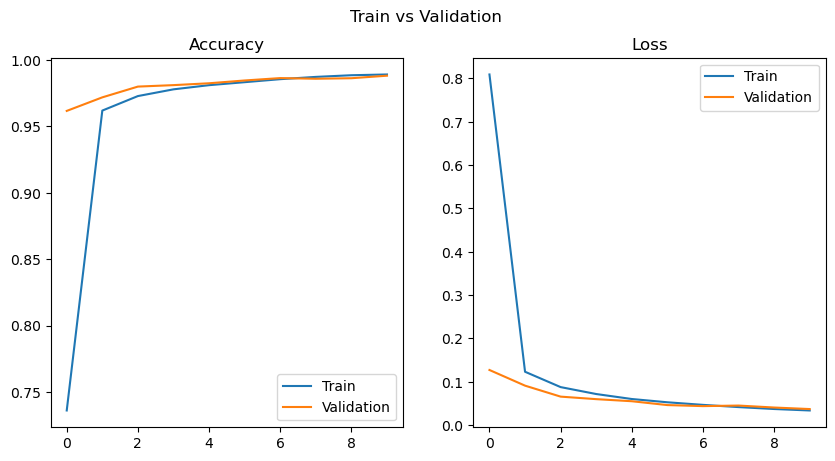

In [6]:
plot_graph(training_logs)

-------------
# Change classifier head to train another dataset

In [7]:
transform = transforms.Compose(
        [transforms.Resize((32, 32)),
         transforms.Grayscale(num_output_channels=3),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
         ])

# Create datasets for training & validation, download if necessary
# handwritten
training_set = torchvision.datasets.SVHN('/home/crueang/Chaks/AIOT/5_1_inclass/data', split='train', transform=transform, download=True)
validation_set = torchvision.datasets.SVHN('/home/crueang/Chaks/AIOT/5_1_inclass/data', split='test', transform=transform, download=True)
# training_set = torchvision.datasets.QMNIST('./data', what='train', transform=transform, download=True)
# validation_set = torchvision.datasets.QMNIST('./data', what='test10k', transform=transform, download=True)
# object recognition
# training_set = torchvision.datasets.STL10('./data', split='train', transform=transform, download=True)
# validation_set = torchvision.datasets.STL10('./data', split='test', transform=transform, download=True)

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=16, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=16, shuffle=False)

# Class labels
# classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

100%|██████████| 182040794/182040794 [00:26<00:00, 6800806.83it/s] 


100%|██████████| 64275384/64275384 [00:13<00:00, 4624145.68it/s] 


Training set has 73257 instances
Validation set has 26032 instances


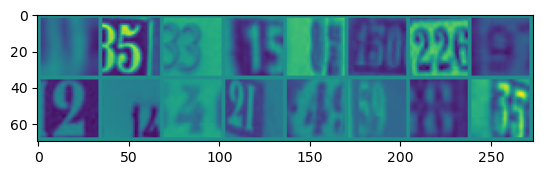

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg)
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
# print('  '.join(classes[labels[j]] for j in range(16)))

Change new head & some FC layers, fine-tune some layers and train our new head


```
# Optimization for ever layer at the same velocity and direction
optimizer = torch.optim.SGD(new_model_head.parameters(), lr=0.001, momentum=0.9)

                    ||||||||||
                    ||||||||||
                    ||||||||||
                    VVVVVVVVVV

# Optimization for some layers, out of them got freezing or fine-tuning with a few lr
lr = 1e-2
optimizer = torch.optim.SGD(
    [dict(params=new_model_head.conv1.parameters(), lr=0), # freeze them preferably
      dict(params=new_model_head.conv2.parameters(), lr=...), # relatively few adjusting lr to fine-tune
      dict(params=new_model_head.fc1.parameters(), lr=...), # relatively few adjusting lr to fine-tune
      dict(params=new_model_head.fc2.parameters()), # train from scratch for all new heads
      dict(params=new_model_head.fc3.parameters()), # train from scratch for all new heads
      ],
    lr=lr,  # learning rate for all layers if none of any setting individual
    momentum=0.9,
)
```



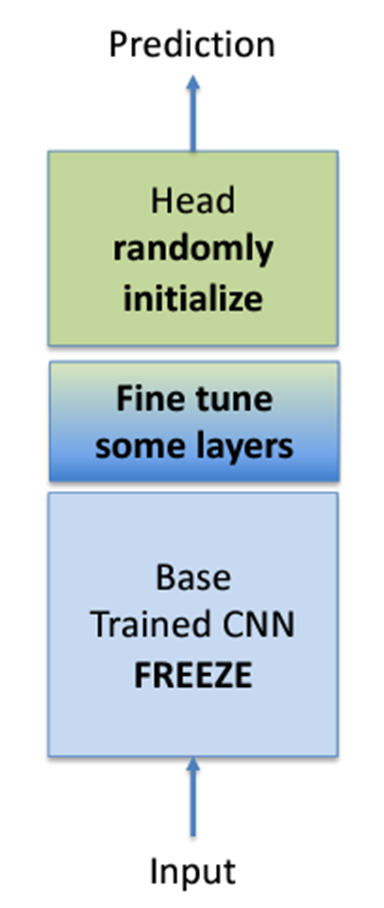

In [30]:
# Model init
new_model_head = handwrittenmodel().to(device)
#---load and replace new hidden layers---
load_pretrained = True

if load_pretrained:
  checkpoint = torch.load(f'/home/crueang/Chaks/AIOT/5_1_inclass/cp/W5-1_best_pretrainedmodel_{EPOCHS_pretrained}ep.pth')
  new_model_head.load_state_dict(checkpoint, strict=False)


# เลเยอร์ fc ใหม่ (New classifier head)
#conv1 ---> conv2 ---> flattening ---> fc1 ---> fc2 ---> fc3
# ...        ...          20*3*3        256      128      10

new_model_head.fc2 = nn.Linear(128, 32).to(device)
new_model_head.fc3 = nn.Linear(32, 10).to(device)

print(new_model_head)

freeze_layers = []

for name, param in new_model_head.named_parameters():
  if name in freeze_layers:
    param.requires_grad = False
  else:
    param.requires_grad = True

# for name, param in new_model_head.named_parameters():
#     print(f"Layer: {name} | Requires Grad: {param.requires_grad}")

#---------------------------------------
summary(new_model_head, (3, 32, 32))

# Loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Optimization for some layers, out of them got freezing or fine-tuning with a few lr
lr = 5e-3
optimizer = torch.optim.SGD(
    [
      dict(params=new_model_head.conv1.parameters(), lr=1e-4), # best at 1e-4
      dict(params=new_model_head.conv2.parameters(), lr=1e-3),  # best at 1e-3
      dict(params=new_model_head.fc1.parameters(), lr=1e-3),  # best at 1e-3
      dict(params=new_model_head.fc2.parameters(), lr=5e-3), # best at 5e-3
      dict(params=new_model_head.fc3.parameters(), lr=5e-3), # best at 5e-3
      ],
    lr=lr,  # learning rate for all layers if none of any setting individual
    momentum=0.9,
)

epoch_number = 0

EPOCHS_finetune = 2
filename = 'fine-tune ทุกเลเยอร์'
path_save_cp = '/home/crueang/Chaks/AIOT/5_1_inclass/cp/'
best_vloss = 1_000_000.
training_logs = {"train_loss": [],  "train_acc": [], "validate_loss": [], "validate_acc": []}

handwrittenmodel(
  (conv1): Conv2d(3, 10, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=180, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 16, 16]             490
         MaxPool2d-2             [-1, 10, 8, 8]               0
            Conv2d-3             [-1, 20, 6, 6]           1,820
         MaxPool2d-4             [-1, 20, 3, 3]               0
            Linear-5                  [-1, 128]          23,168
            Linear-6                   [-1, 32]           4,128
            Linear-7                   [-1, 10]             33

/tmp/ipykernel_1994003/340040405.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f'/home/crueang/Chaks/AIOT/5_1_inclass/cp/W5-1_best_pretrainedmo

In [31]:
# @title Default title text
device = 'cuda'
t_0_accelerated = time.time()
for epoch in range(EPOCHS_finetune):
    train_loss, train_correct = 0, 0
    # Make sure gradient tracking is on, and do a pass over the data
    new_model_head.train(True)
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = new_model_head(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == labels).float().sum().item()

    training_logs["train_loss"].append(train_loss / len(training_loader))
    training_logs["train_acc"].append(train_correct / len(training_loader.dataset))

    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    new_model_head.eval()
    # Disable gradient computation and reduce memory consumption.
    valid_loss, valid_correct = 0, 0
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)
            voutputs = new_model_head(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            valid_loss += loss_fn(voutputs, vlabels).item()
            valid_correct += (voutputs.argmax(1) == vlabels).float().sum().item()
        # save validation logs
        training_logs["validate_loss"].append(valid_loss / len(validation_loader))
        training_logs["validate_acc"].append(valid_correct / len(validation_loader.dataset))

    if epoch % 1 == 0:
        print(f"Epochs {epoch+1}".ljust(10),
            f"train loss {training_logs['train_loss'][-1]:.5f}",
            f"train acc {training_logs['train_acc'][-1]:.5f}",

            f"validate loss {training_logs['validate_loss'][-1]:.5f}",
            f"validate acc {training_logs['validate_acc'][-1]:.5f}",
            )
        print("-"*80)

    # Track best performance, and save the model's state
    # if valid_loss < best_vloss:
    #     best_vloss = valid_loss
    #     # model_path = 'model_{}_{}'.format(timestamp, epoch_number)
    #     if not os.path.exists(path_save_cp): os.mkdir(path_save_cp)
    #     torch.save(new_model_head.state_dict(), path_save_cp+f'W5-1_best_resumemodel_{filename}ep.pth')

    epoch_number += 1

t_end_accelerated = time.time()-t_0_accelerated
print(f"Time consumption for accelerated CUDA training (device:{device}): {t_end_accelerated} sec")

Epochs 1   train loss 0.95039 train acc 0.69707 validate loss 0.70191 validate acc 0.79130
--------------------------------------------------------------------------------
Epochs 2   train loss 0.58444 train acc 0.81913 validate loss 0.57482 validate acc 0.83075
--------------------------------------------------------------------------------
Time consumption for accelerated CUDA training (device:cuda): 58.394200563430786 sec


-----
# In-class exercise
ลองกำหนดโมเดลโดยเปลี่ยนหัวคัดแยกประเภท (classifier head) เพื่อใช้กับ SVHN ทำการ fine-tune layers (ปรับ lr ให้ดีที่สุดเท่าที่ทำได้) เปรียบเทียบผลความแม่นยำ (Accuracy) จาก 5 ข้อย่อยด้านล่าง
 \
กำหนดให้โมเดลเรียนรู้แค่อย่างละ 2 epoches max ด้วย SVHN dataset และใช้ learning rate ต่ำกว่า 1e-3 ในแต่ละ fine-tune layer

```
# เลเยอร์ fc ใหม่ (New classifier head)
conv1 ---> conv2 ---> flattening ---> fc1 ---> fc2 ---> fc3
 ...        ...          20*3*3        256      128      10
```

1. freeze ทุกเลเยอร์/fine-tune fc1
```
conv1 ---> conv2 ---> flattening ---> fc1 ---> fc2 ---> fc3
freeze     freeze         ...        freeze    freeze    hot
```

2. freeze ทุกเลเยอร์/fine-tune fc2-fc1
```
conv1 ---> conv2 ---> flattening ---> fc1 ---> fc2 ---> fc3
freeze     freeze         ...        freeze     hot      hot
```

3. freeze encoder/fine-tune classifier head
```
conv1 ---> conv2 ---> flattening ---> fc1 ---> fc2 ---> fc3
freeze     freeze         ...         hot      hot      hot
```

4. freeze แค่ conv1
```
conv1 ---> conv2 ---> flattening ---> fc1 ---> fc2 ---> fc3
freeze      hot          ...          hot      hot      hot
```

4. fine-tune ทุกเลเยอร์
```
conv1 ---> conv2 ---> flattening ---> fc1 ---> fc2 ---> fc3
  hot       hot          ...          hot      hot      hot
```


--------------------
# Homework
- ออกแบบโมเดลแบบ โดยใช้ InceptionV3 block (ภาพขวา) กับฟีเจอร์ ที่ออกจาก conv-pool ชั้นแรก
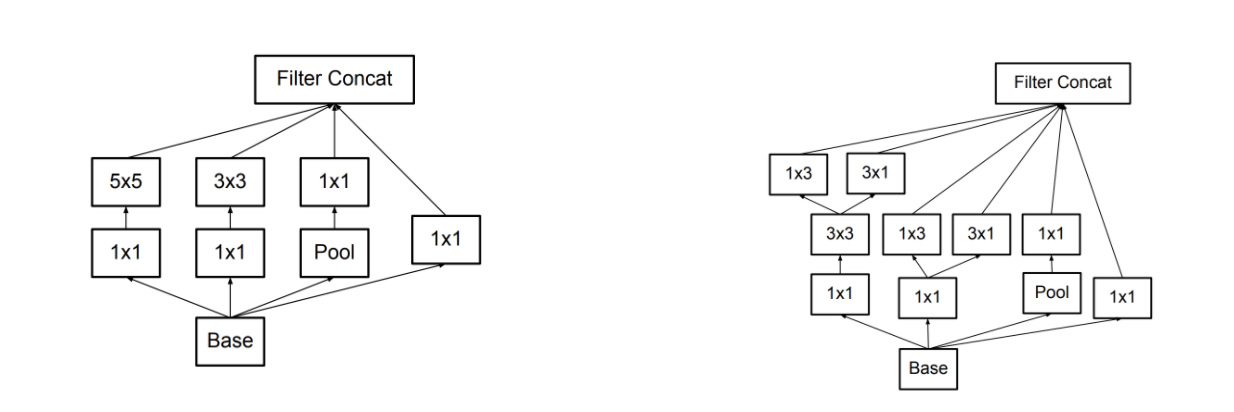

- [source dataset = Caltech101] ฝึกฝน pretained model บนข้อมูล source จำนวนวนรอบมากกว่าหรือเท่ากับ 10 รอบ (>= 10 epoches)
- [target dataset = STL10] จำนวนวนซ้ำที่ 5 รอบ (5 epoches) สำหรับการฝึกฝนบนข้อมูล target

\
1.) [Pretraining part] เทียบโมเดลที่ฝึกฝน Caltech101 ด้วย InceptionV1 กับ InceptionV3 ทั้งด้านประสิทธิภาพและทรัพยากรที่ใช้\
2.) [Resume training] ฝึกฝน STL10 ที่ใช้ pre-trained weight จาก Caltech101 เรียนในทุกเลเยอร์ (learning rate เดียวกันทุกเลเยอร์) คล้ายกับการบ้าน W4-2\
3.) [Fine-tune training] ฝึกฝน STL10 ที่ใช้ pre-trained weight จาก Caltech101 แบบ fine-tune weight บางเลเยอร์ (learning rate ค่อยปรับไล่ระดับ)\
4.)  เปรีบเทียบผลลัพธ์เชิงปริมาณและการแสดงผลทั้ง Quantitative (Accuracy, loss, precision, recall, F1-score, NMI/RI scores, resource usage) and visualization results (t-SNE, plot) จากข้อ 1 และ 2